# Coronavirus Data Analysis

In [1]:
import pandas as pd
import numpy as np

In [2]:
spark.sparkContext.applicationId

'application_1631937024592_0311'

In [3]:
pd.options.display.max_columns = 35

In [4]:
spark.stop()

spark = SparkSession.builder \
                    .config('spark.dynamicAllocation.maxExecutors', 50) \
                    .config('spark.executor.cores', '3') \
                    .config('spark.executor.memory', '15g') \
                    .config('spark.driver.memory', '40g') \
                    .config('spark.python.worker.memory', '2g') \
                    .config('spark.sql.shuffle.partitions', '2000') \
                    .config('spark.network.timeout', '2000') \
                    .config('spark.sql.broadcastTimeout', '2000') \
                    .config('spark.driver.maxResultSize', '6g') \
                    .config('mapreduce.fileoutputcommitter.algorithm.version', '2') \
                    .getOrCreate()
            
spark.sparkContext.applicationId

'application_1631937024592_0312'

In [5]:
from foresight.discern import broadcast_discern, push_discern, pop_discern

### care management new default will be 5e259fd5-75b5-4d49-82d3-2d4e92dca831 for any new clients or 
###  any algorithm wiki not line for line with Cerner Standard then would be using the new context  

pd.set_option('display.max_colwidth', None)

# Location of the discernontology database
root = 's3://consult-datalab-persistence-s3-data/discernontology/v1/'   ##<------------- change it to your stack without the v1/

contextid = ['da0acee6-1e2e-4384-9fc7-a58c259d0c50', '5E259FD575B54D4982D32D4E92DCA831'] 

# Loop that removes all hypthens and captializes all letters. Sets up the file location
for contextid in contextid:
    contextid = contextid.upper().replace("-", "")
    push_discern(spark, contextid, discern_root=root)
    print(contextid)

defaultcontext = 'DA0ACEE61E2E43849FC7A58C259D0C50'   
defaultcontext1 = '5E259FD575B54D4982D32D4E92DCA831' 

DA0ACEE61E2E43849FC7A58C259D0C50
5E259FD575B54D4982D32D4E92DCA831


In [6]:
db = "real_world_data_2021_Q2"
spark.sql("USE {}".format(db))
print("Using database: {},".format(db))

Using database: real_world_data_2021_Q2,


In [7]:
spark.sql('show tables').toPandas()

,database,tableName,isTemporary
0,real_world_data_2021_q2,allergy,False
1,real_world_data_2021_q2,clinical_event,False
2,real_world_data_2021_q2,condition,False
3,real_world_data_2021_q2,demographics,False
4,real_world_data_2021_q2,encounter,False
5,real_world_data_2021_q2,immunization,False
6,real_world_data_2021_q2,lab,False
7,real_world_data_2021_q2,measurement,False
8,real_world_data_2021_q2,medication,False
9,real_world_data_2021_q2,medication_administration,False


### Create Variables for Queries

In [8]:
# Look back days variables
daysInterval = 365
print(daysInterval)
maxDays = 365
print(maxDays)
oneYearInterval=365
print(oneYearInterval)

# Username variable
user_id = 'rc047407'           ####<-------------------- change to your user id (Ex: tl068507)
userName = 'user_' + user_id
print(userName)

# Algorithm name variable
algorithmName='CoronavirusLengthOfStay_HighLevel'
print(algorithmName)

365
365
365
user_rc047407
CoronavirusLengthOfStay_HighLevel


In [9]:
spark.sql("""CREATE SCHEMA IF NOT EXISTS {userName}""".format(**{
    'userName':userName
})).show()

++
||
++
++



In [10]:
conavirusPatientsByBedsideDf =  spark.sql(f"""


    SELECT distinct
        h.tenant
        ,h.personId
        ,t.bed_size
        ,1 as has_or_been_exposed_to_coronavirus
        ,h.age

        FROM {userName}.{algorithmName}_Hospital h
                    
        JOIN {db}.tenant_attributes t
           ON  t.tenant = h.tenant
                    
                       
                                   
   
       

""")

In [11]:
# Drop existing table, if there was one 
spark.sql(f"""DROP TABLE IF EXISTS {userName}.{algorithmName}_ConavirusPatientsByBedsize""").show() 

++
||
++
++



In [12]:
conavirusPatientsByBedsideDf.write.saveAsTable(f"""{userName}.{algorithmName}_ConavirusPatientsByBedsize """)

In [13]:
allDf = spark.sql(f"""
  select
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay)) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
 
            where    
                  datediff(h.serviceDate, h.dischargeDate) < 0
                  and h.length_of_stay > 0
                  and length(h.dischargeDate) > 3
                  and length(h.serviceDate) > 3 
                 
  
""") 

In [14]:
mean_length_of_stay = allDf.first().mean_length_of_stay
std_length_of_stay = allDf.first().std_length_of_stay
print(mean_length_of_stay)
print(std_length_of_stay)
print(allDf.toPandas())

9.76
13.0
   count_of_patients  min_length_of_stay  max_length_of_stay  \
0             309364                   2                1553   

   mean_length_of_stay  std_length_of_stay  
0                 9.76                13.0  


In [15]:
spark.sql(f"""select distinct bed_size 
             from {db}.tenant_attributes t
             
  
        
""").toPandas()                 

,bed_size
0,None
1,100-199
2,300-499
3,500-999
4,200-299
5,>=1000
6,<100


In [16]:
bedsize_100_199  = spark.sql(f"""
  select
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay)) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  join {userName}.{algorithmName}_ConavirusPatientsByBedsize b
    on h.personid = b.personId
      and h.tenant = b.tenant

      
  where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      
      and b.bed_size = '100-199'

  
  
""")

In [17]:
mean_length_of_stay_bedsize_100_199 = bedsize_100_199.first().mean_length_of_stay
std_length_of_stay_bedsize_100_199 = bedsize_100_199.first().std_length_of_stay
print(mean_length_of_stay_bedsize_100_199)
print(std_length_of_stay_bedsize_100_199)
print(bedsize_100_199.toPandas())

8.87
10.0
   count_of_patients  min_length_of_stay  max_length_of_stay  \
0               2179                   2                 154   

   mean_length_of_stay  std_length_of_stay  
0                 8.87                10.0  


In [18]:
bedsize_200_299  = spark.sql(f"""
  select
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay)) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  join {userName}.{algorithmName}_ConavirusPatientsByBedsize b
    on h.personid = b.personId
      and h.tenant = b.tenant

      
  where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      
      and b.bed_size = '200-299'

  
  
""")

In [19]:
mean_length_of_stay_bedsize_200_299 = bedsize_200_299.first().mean_length_of_stay
std_length_of_stay_bedsize_200_299 = bedsize_200_299.first().std_length_of_stay
print(mean_length_of_stay_bedsize_200_299)
print(std_length_of_stay_bedsize_200_299)
print(bedsize_200_299.toPandas())

8.83
12.0
   count_of_patients  min_length_of_stay  max_length_of_stay  \
0               5344                   2                 345   

   mean_length_of_stay  std_length_of_stay  
0                 8.83                12.0  


In [20]:
bedsize_300_499  = spark.sql(f"""
  select
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay)) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  join {userName}.{algorithmName}_ConavirusPatientsByBedsize b
    on h.personid = b.personId
      and h.tenant = b.tenant

      
  where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      
      and b.bed_size = '300-499'

  
  
""")

In [21]:
mean_length_of_stay_bedsize_300_499 = bedsize_300_499.first().mean_length_of_stay
std_length_of_stay_bedsize_300_499 = bedsize_300_499.first().std_length_of_stay
print(mean_length_of_stay_bedsize_300_499)
print(std_length_of_stay_bedsize_300_499)
print(bedsize_300_499.toPandas())

9.53
11.0
   count_of_patients  min_length_of_stay  max_length_of_stay  \
0              40014                   2                 861   

   mean_length_of_stay  std_length_of_stay  
0                 9.53                11.0  


In [22]:
bedsize_500_999  = spark.sql(f"""
  select
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay)) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  join {userName}.{algorithmName}_ConavirusPatientsByBedsize b
    on h.personid = b.personId
      and h.tenant = b.tenant

      
  where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      
      and b.bed_size = '500-999'

  
  
""")

In [23]:
mean_length_of_stay_bedsize_500_999 = bedsize_500_999.first().mean_length_of_stay
std_length_of_stay_bedsize_500_999 = bedsize_500_999.first().std_length_of_stay
print(mean_length_of_stay_bedsize_500_999)
print(std_length_of_stay_bedsize_500_999)
print(bedsize_500_999.toPandas())

9.72
14.0
   count_of_patients  min_length_of_stay  max_length_of_stay  \
0              60204                   2                1364   

   mean_length_of_stay  std_length_of_stay  
0                 9.72                14.0  


In [24]:
bedsize_gte_1000  = spark.sql(f"""
  select
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay)) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  join {userName}.{algorithmName}_ConavirusPatientsByBedsize b
    on h.personid = b.personId
      and h.tenant = b.tenant

      
  where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      
      and b.bed_size = '>=1000'

  
  
""")

In [25]:
mean_length_of_stay_bedsize_gte_1000 = bedsize_gte_1000.first().mean_length_of_stay
std_length_of_stay_bedsize_gte_1000 = bedsize_gte_1000.first().std_length_of_stay
print(mean_length_of_stay_bedsize_gte_1000)
print(std_length_of_stay_bedsize_gte_1000)
print(bedsize_gte_1000.toPandas())

9.75
12.0
   count_of_patients  min_length_of_stay  max_length_of_stay  \
0             239924                   2                1553   

   mean_length_of_stay  std_length_of_stay  
0                 9.75                12.0  


In [26]:
bedsize_le_100  = spark.sql(f"""
  select
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay)) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  join {userName}.{algorithmName}_ConavirusPatientsByBedsize b
    on h.personid = b.personId
      and h.tenant = b.tenant

      
  where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      
      and b.bed_size = '<100'

  
  
""")

In [27]:
mean_length_of_stay_bedsize_le_100  = bedsize_le_100 .first().mean_length_of_stay
std_length_of_stay_bedsize_le_100  = bedsize_le_100 .first().std_length_of_stay
print(mean_length_of_stay_bedsize_le_100 )
print(std_length_of_stay_bedsize_le_100 )
print(bedsize_le_100 .toPandas())

7.74
24.0
   count_of_patients  min_length_of_stay  max_length_of_stay  \
0               3831                   2                1039   

   mean_length_of_stay  std_length_of_stay  
0                 7.74                24.0  


In [28]:
spark.sql(f"""
  select t.speciality,
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay),2) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant
      
  join {db}.tenant_attributes t
            ON  h.tenant = t.tenant  
     
   where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
 
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      

        and  ( datediff(h.serviceDate, v.vaccine_date) <= 0
               or v.vaccine_date is null) 
               
               
    --        and  ( datediff(h.serviceDate, v.vaccine_date) > 0
    --           and v.vaccine_date is not null)        
      

 
  group by 1 
  
 
  order by 1
  
     
""").toPandas()

,speciality,count_of_patients,min_length_of_stay,max_length_of_stay,mean_length_of_stay,std_length_of_stay
0,Academic Medical Center,9636,2,841,10.10,15.76
1,Community Hospital,3460,2,1039,8.56,24.11
2,Critical Access Hospital,1240,2,234,6.02,7.93
3,Hospital,57351,2,861,9.95,12.11
4,IDN/Regional Health Authority,239645,2,1553,9.74,12.44
5,Pediatric Medical Center,1049,2,612,10.11,30.45


In [29]:
spark.sql(f"""
  select t.speciality,
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay),2) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant
      
  join {db}.tenant_attributes t
            ON  h.tenant = t.tenant  
     
   where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
 
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      

  --      and  ( datediff(h.serviceDate, v.vaccine_date) <= 0
  --             or v.vaccine_date is null) 
               
               
            and  ( datediff(h.serviceDate, v.vaccine_date) > 0
               and v.vaccine_date is not null)        
      

 
  group by 1 
  
 
  order by 1
  
     
""").toPandas()

,speciality,count_of_patients,min_length_of_stay,max_length_of_stay,mean_length_of_stay,std_length_of_stay
0,Academic Medical Center,8,2,27,9.25,9.16
1,Community Hospital,20,3,10,5.45,2.68
2,Critical Access Hospital,4,3,10,4.75,3.50
3,Hospital,77,2,50,9.23,8.65
4,IDN/Regional Health Authority,263,2,23,6.97,4.40


In [30]:
spark.sql(f"""
  select t.bed_size,
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay),2) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant
      
  join {db}.tenant_attributes t
            ON  h.tenant = t.tenant  
     
   where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
 
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      

        and  ( datediff(h.serviceDate, v.vaccine_date) <= 0
               or v.vaccine_date is null) 
               
               
    --        and  ( datediff(h.serviceDate, v.vaccine_date) > 0
    --           and v.vaccine_date is not null)        
      

 
  group by 1 
  
 
  order by 1
  
     
""").toPandas()

,bed_size,count_of_patients,min_length_of_stay,max_length_of_stay,mean_length_of_stay,std_length_of_stay
0,100-199,2182,2,154,8.89,10.29
1,200-299,5385,2,345,8.88,12.81
2,300-499,32562,2,861,9.64,11.99
3,500-999,61233,2,1364,9.68,14.00
4,<100,3959,2,1039,8.27,26.61
5,>=1000,207060,2,1553,9.86,12.10


In [31]:
spark.sql(f"""
  select t.bed_size,
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay),2) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant
      
  join {db}.tenant_attributes t
            ON  h.tenant = t.tenant  
     
   where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
 
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      

   --     and  ( datediff(h.serviceDate, v.vaccine_date) <= 0
   --            or v.vaccine_date is null) 
               
               
            and  ( datediff(h.serviceDate, v.vaccine_date) > 0
               and v.vaccine_date is not null)        
      

 
  group by 1 
  
 
  order by 1
  
     
""").toPandas()

,bed_size,count_of_patients,min_length_of_stay,max_length_of_stay,mean_length_of_stay,std_length_of_stay
0,100-199,2,8,8,8.00,0.00
1,200-299,5,3,5,3.80,1.10
2,300-499,19,2,27,7.00,6.19
3,500-999,122,2,50,8.37,7.35
4,<100,27,2,20,6.04,4.00
5,>=1000,197,2,23,7.08,4.55


In [32]:
spark.sql(f"""
  select t.segment,
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay),2) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant
      
  join {db}.tenant_attributes t
            ON  h.tenant = t.tenant  
     
   where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
 
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      

   --     and  ( datediff(h.serviceDate, v.vaccine_date) <= 0
   --            or v.vaccine_date is null) 
               
               
            and  ( datediff(h.serviceDate, v.vaccine_date) > 0
               and v.vaccine_date is not null)        
      

 
  group by 1 
  
 
  order by 1
  
     
""").toPandas()

,segment,count_of_patients,min_length_of_stay,max_length_of_stay,mean_length_of_stay,std_length_of_stay
0,Academic,13,2,27,10.08,8.03
1,Childrens,2,8,8,8.00,0.00
2,Community Healthcare,19,2,10,5.47,2.80
3,Community Hospital,3,3,20,9.00,9.54
4,Critical Access,2,3,10,6.50,4.95
5,IDN,217,2,37,7.80,5.76
6,Regional Hospital,116,2,50,6.59,5.42


In [33]:
spark.sql(f"""
  select t.segment,
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay),2) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant
      
  join {db}.tenant_attributes t
            ON  h.tenant = t.tenant  
     
   where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
 
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      

        and  ( datediff(h.serviceDate, v.vaccine_date) <= 0
               or v.vaccine_date is null) 
               
               
   --         and  ( datediff(h.serviceDate, v.vaccine_date) > 0
   --            and v.vaccine_date is not null)        
      

 
  group by 1 
  
 
  order by 1
  
     
""").toPandas()

,segment,count_of_patients,min_length_of_stay,max_length_of_stay,mean_length_of_stay,std_length_of_stay
0,Academic,19175,2,841,10.27,14.12
1,Childrens,2762,2,861,9.56,28.83
2,Community Healthcare,959,2,234,5.74,8.54
3,Community Hospital,2310,2,1039,8.71,29.11
4,Critical Access,390,2,30,5.50,3.81
5,IDN,241236,2,1553,9.78,11.85
6,Regional Hospital,45549,2,1364,9.63,13.98


In [34]:
import matplotlib.pyplot as plt
from scipy.stats import norm

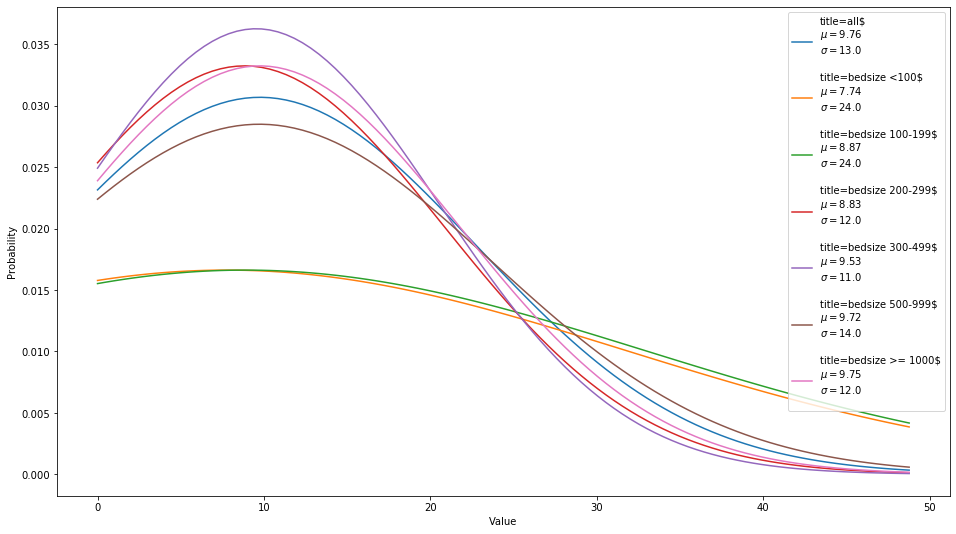

In [35]:
# generating multiple normal distributions
max_length_of_stay=mean_length_of_stay + 3*std_length_of_stay

domain = np.linspace(0, max_length_of_stay, 100) # dividing the distance between 0 and max_length_of_stay into 100 points

means = [mean_length_of_stay, mean_length_of_stay_bedsize_le_100, mean_length_of_stay_bedsize_100_199,
         mean_length_of_stay_bedsize_200_299, mean_length_of_stay_bedsize_300_499, mean_length_of_stay_bedsize_500_999,
         mean_length_of_stay_bedsize_gte_1000 ]
std_values = [std_length_of_stay, std_length_of_stay_bedsize_le_100, std_length_of_stay_bedsize_le_100,
              std_length_of_stay_bedsize_200_299, std_length_of_stay_bedsize_300_499, std_length_of_stay_bedsize_500_999,
              std_length_of_stay_bedsize_gte_1000]
title_values = ["all", "bedsize <100", "bedsize 100-199", "bedsize 200-299", "bedsize 300-499", "bedsize 500-999",
                "bedsize >= 1000"]

plt.figure(figsize=(16, 9))
for title, mu, std in zip(title_values, means, std_values):
    # pdf stands for Probability Density Function, which is the plot the probabilities of each range of values
    probabilities = norm.pdf(domain, mu, std)
    plt.plot(domain, probabilities, label=f"title={title}$\n$\mu={mu}$\n$\sigma={std}$\n")

plt.legend()
plt.xlabel("Value")
plt.ylabel("Probability")
plt.show()

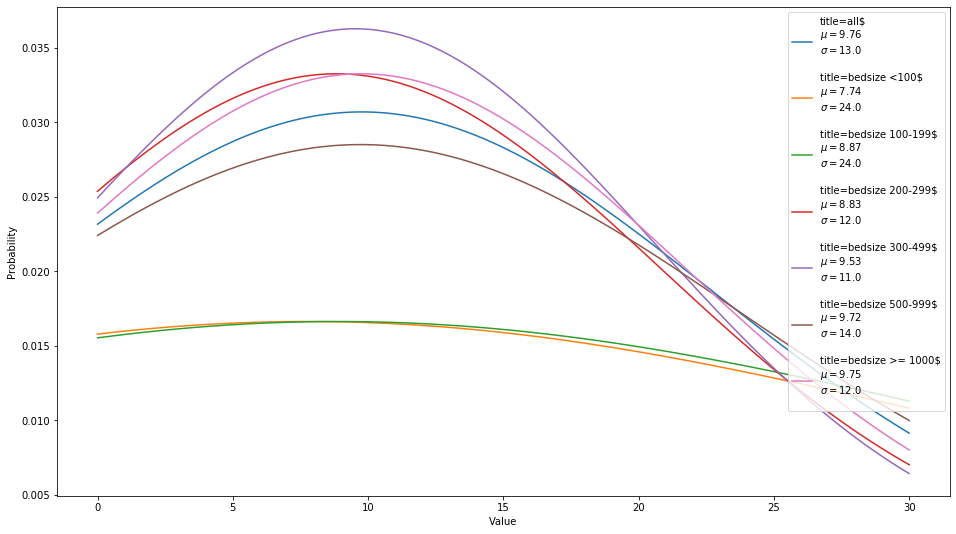

In [36]:
# generating multiple normal distributions
max_length_of_stay=30

domain = np.linspace(0, max_length_of_stay, 100) # dividing the distance between 0 and max_length_of_stay into 100 points

means = [mean_length_of_stay, mean_length_of_stay_bedsize_le_100, mean_length_of_stay_bedsize_100_199,
         mean_length_of_stay_bedsize_200_299, mean_length_of_stay_bedsize_300_499, mean_length_of_stay_bedsize_500_999,
         mean_length_of_stay_bedsize_gte_1000 ]
std_values = [std_length_of_stay, std_length_of_stay_bedsize_le_100, std_length_of_stay_bedsize_le_100,
              std_length_of_stay_bedsize_200_299, std_length_of_stay_bedsize_300_499, std_length_of_stay_bedsize_500_999,
              std_length_of_stay_bedsize_gte_1000]
title_values = ["all", "bedsize <100", "bedsize 100-199", "bedsize 200-299", "bedsize 300-499", "bedsize 500-999",
                "bedsize >= 1000"]

plt.figure(figsize=(16, 9))
for title, mu, std in zip(title_values, means, std_values):
    # pdf stands for Probability Density Function, which is the plot the probabilities of each range of values
    probabilities = norm.pdf(domain, mu, std)
    plt.plot(domain, probabilities, label=f"title={title}$\n$\mu={mu}$\n$\sigma={std}$\n")

plt.legend()
plt.xlabel("Value")
plt.ylabel("Probability")
plt.show()

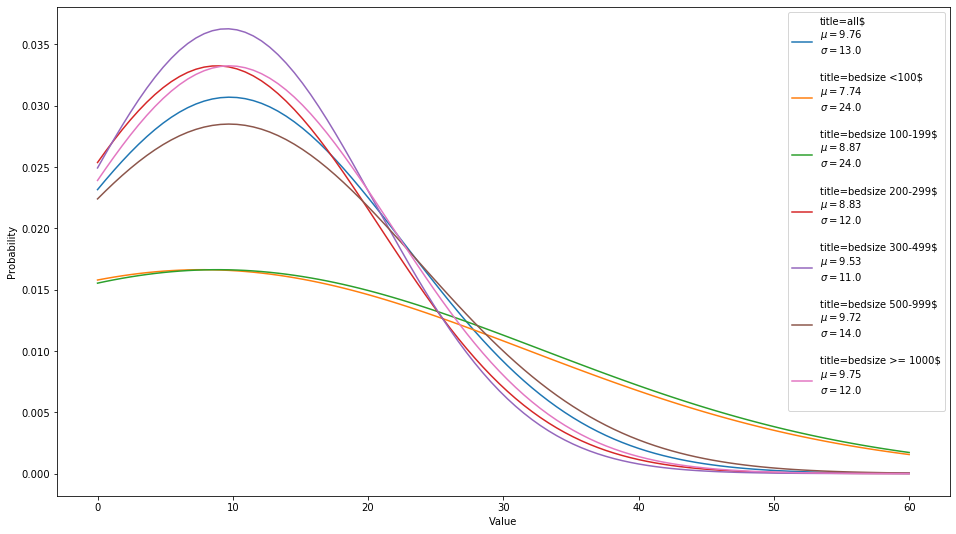

In [37]:
# generating multiple normal distributions
max_length_of_stay=60

domain = np.linspace(0, max_length_of_stay, 100) # dividing the distance between 0 and max_length_of_stay into 100 points

means = [mean_length_of_stay, mean_length_of_stay_bedsize_le_100, mean_length_of_stay_bedsize_100_199,
         mean_length_of_stay_bedsize_200_299, mean_length_of_stay_bedsize_300_499, mean_length_of_stay_bedsize_500_999,
         mean_length_of_stay_bedsize_gte_1000 ]
std_values = [std_length_of_stay, std_length_of_stay_bedsize_le_100, std_length_of_stay_bedsize_le_100,
              std_length_of_stay_bedsize_200_299, std_length_of_stay_bedsize_300_499, std_length_of_stay_bedsize_500_999,
              std_length_of_stay_bedsize_gte_1000]
title_values = ["all", "bedsize <100", "bedsize 100-199", "bedsize 200-299", "bedsize 300-499", "bedsize 500-999",
                "bedsize >= 1000"]

plt.figure(figsize=(16, 9))
for title, mu, std in zip(title_values, means, std_values):
    # pdf stands for Probability Density Function, which is the plot the probabilities of each range of values
    probabilities = norm.pdf(domain, mu, std)
    plt.plot(domain, probabilities, label=f"title={title}$\n$\mu={mu}$\n$\sigma={std}$\n")

plt.legend()
plt.xlabel("Value")
plt.ylabel("Probability")
plt.show()

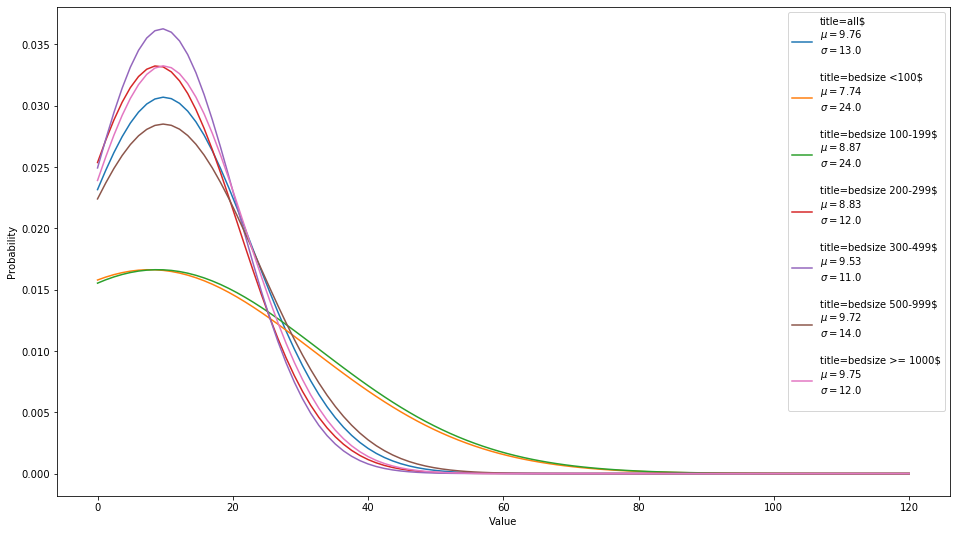

In [38]:
# generating multiple normal distributions
max_length_of_stay=120

domain = np.linspace(0, max_length_of_stay, 100) # dividing the distance between 0 and max_length_of_stay into 100 points

means = [mean_length_of_stay, mean_length_of_stay_bedsize_le_100, mean_length_of_stay_bedsize_100_199,
         mean_length_of_stay_bedsize_200_299, mean_length_of_stay_bedsize_300_499, mean_length_of_stay_bedsize_500_999,
         mean_length_of_stay_bedsize_gte_1000 ]
std_values = [std_length_of_stay, std_length_of_stay_bedsize_le_100, std_length_of_stay_bedsize_le_100,
              std_length_of_stay_bedsize_200_299, std_length_of_stay_bedsize_300_499, std_length_of_stay_bedsize_500_999,
              std_length_of_stay_bedsize_gte_1000]
title_values = ["all", "bedsize <100", "bedsize 100-199", "bedsize 200-299", "bedsize 300-499", "bedsize 500-999",
                "bedsize >= 1000"]

plt.figure(figsize=(16, 9))
for title, mu, std in zip(title_values, means, std_values):
    # pdf stands for Probability Density Function, which is the plot the probabilities of each range of values
    probabilities = norm.pdf(domain, mu, std)
    plt.plot(domain, probabilities, label=f"title={title}$\n$\mu={mu}$\n$\sigma={std}$\n")

plt.legend()
plt.xlabel("Value")
plt.ylabel("Probability")
plt.show()

In [39]:
byUsingVaccinationStayOfLengthDf = spark.sql(f"""
  select
       count(distinct h.personId) as count
       ,h.length_of_stay
       ,b.bed_size
       
  from {userName}.{algorithmName}_Hospital h
  join {userName}.{algorithmName}_ConavirusPatientsByBedsize b
    on h.personid = b.personId
      and h.tenant = b.tenant

      
  where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
      and h.length_of_stay < 180
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      
  group by 2,3    

""")

In [40]:
x5 = list(byUsingVaccinationStayOfLengthDf.filter(byUsingVaccinationStayOfLengthDf.bed_size == '>=1000').select('count').toPandas()['count'])
y5 = list(byUsingVaccinationStayOfLengthDf.filter(byUsingVaccinationStayOfLengthDf.bed_size == '>=1000').select('length_of_stay').toPandas()['length_of_stay'])  


In [41]:
x4 = list(byUsingVaccinationStayOfLengthDf.filter(byUsingVaccinationStayOfLengthDf.bed_size == '500-999').select('count').toPandas()['count'])
y4 = list(byUsingVaccinationStayOfLengthDf.filter(byUsingVaccinationStayOfLengthDf.bed_size == '500-999').select('length_of_stay').toPandas()['length_of_stay'])  


In [42]:
x3 = list(byUsingVaccinationStayOfLengthDf.filter(byUsingVaccinationStayOfLengthDf.bed_size == '300-499').select('count').toPandas()['count'])
y3 = list(byUsingVaccinationStayOfLengthDf.filter(byUsingVaccinationStayOfLengthDf.bed_size == '300-499').select('length_of_stay').toPandas()['length_of_stay'])  


In [43]:
x2 = list(byUsingVaccinationStayOfLengthDf.filter(byUsingVaccinationStayOfLengthDf.bed_size == '200-299').select('count').toPandas()['count'])
y2 = list(byUsingVaccinationStayOfLengthDf.filter(byUsingVaccinationStayOfLengthDf.bed_size == '200-299').select('length_of_stay').toPandas()['length_of_stay'])  


In [44]:
x1 = list(byUsingVaccinationStayOfLengthDf.filter(byUsingVaccinationStayOfLengthDf.bed_size == '100-199').select('count').toPandas()['count'])
y1 = list(byUsingVaccinationStayOfLengthDf.filter(byUsingVaccinationStayOfLengthDf.bed_size == '100-199').select('length_of_stay').toPandas()['length_of_stay'])  


In [45]:
x0 = list(byUsingVaccinationStayOfLengthDf.filter(byUsingVaccinationStayOfLengthDf.bed_size == '<100').select('count').toPandas()['count'])
y0 = list(byUsingVaccinationStayOfLengthDf.filter(byUsingVaccinationStayOfLengthDf.bed_size == '<100').select('length_of_stay').toPandas()['length_of_stay'])  


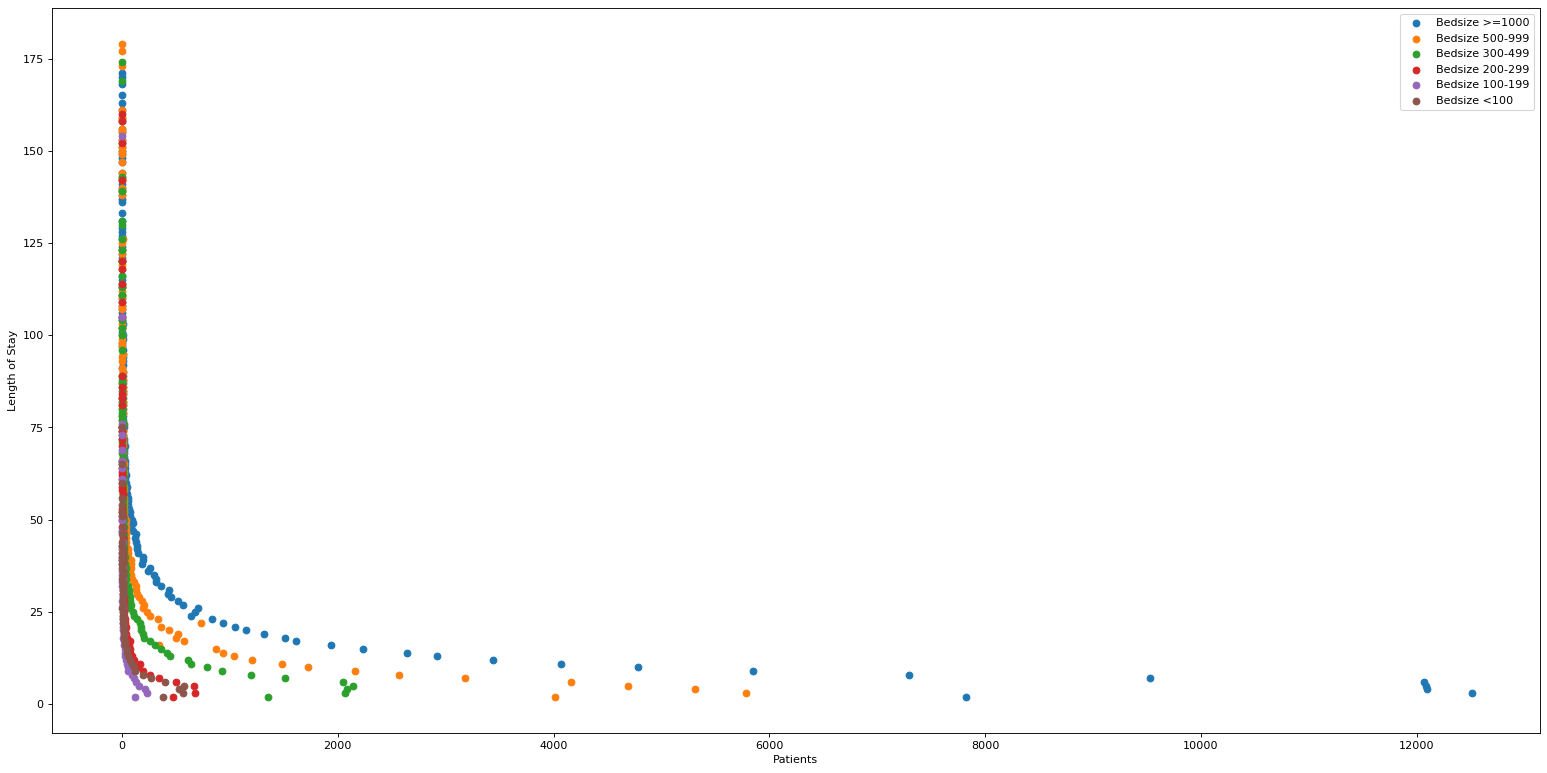

In [46]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(24, 12), dpi=80)
plt.scatter(x5, y5, label='Bedsize >=1000')
plt.scatter(x4, y4, label='Bedsize 500-999')
plt.scatter(x3, y3, label='Bedsize 300-499')
plt.scatter(x2, y2, label='Bedsize 200-299')
plt.scatter(x1, y1, label='Bedsize 100-199')
plt.scatter(x0, y0, label='Bedsize <100')

# plt.xlim(0, 180)
# plt.ylim(0, 500)

plt.ylabel("Length of Stay")
plt.xlabel("Patients")
plt.legend()

plt.show()

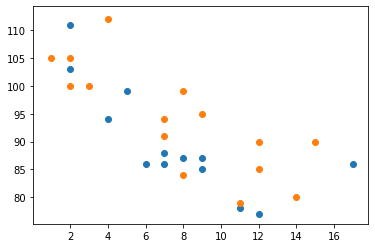

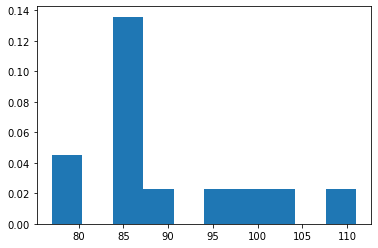

In [47]:
import matplotlib.pyplot as plt
import numpy as np

#day one, the age and speed of 13 cars:
x = np.array([5,7,8,7,2,17,2,9,4,11,12,9,6])
y = np.array([99,86,87,88,111,86,103,87,94,78,77,85,86])
plt.scatter(x, y)

#day two, the age and speed of 15 cars:
x = np.array([2,2,8,1,15,8,12,9,7,3,11,4,7,14,12])
y = np.array([100,105,84,105,90,99,90,95,94,100,79,112,91,80,85])
plt.scatter(x, y)

plt.show()

x = np.array([5,7,8,7,2,17,2,9,4,11,12,9,6])
y = np.array([99,86,87,88,111,86,103,87,94,78,77,85,86])
plt.hist(y, density=True)
plt.show()

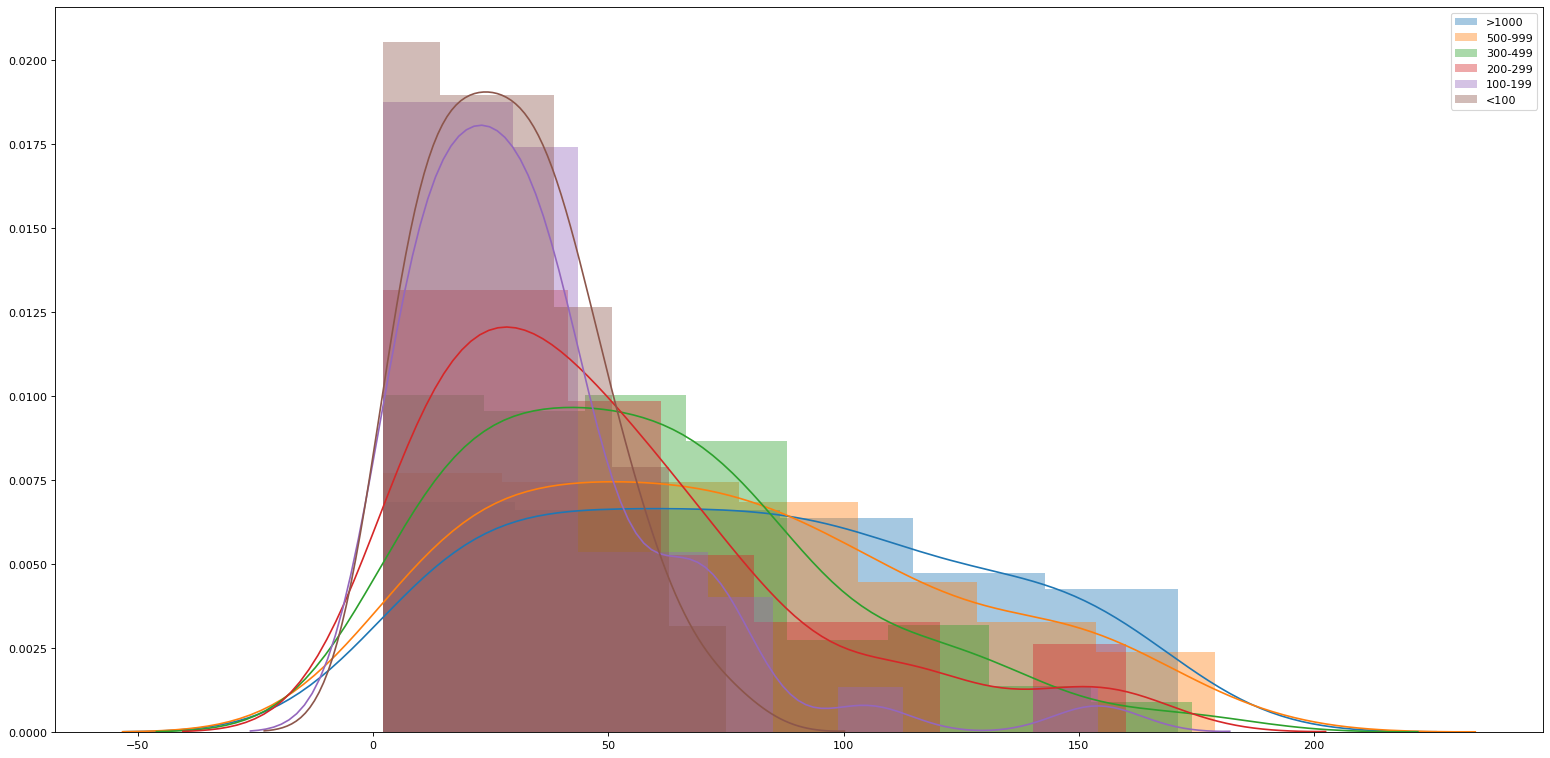

In [48]:
# Solution
import seaborn as sns


plt.subplots(figsize=(24,12), dpi=80)
sns.distplot( y5 , label=">1000")
sns.distplot( y4 , label="500-999")
sns.distplot( y3 , label="300-499")
sns.distplot( y2 , label="200-299")
sns.distplot( y1 , label="100-199")
sns.distplot( y0 , label="<100")

#plt.title('Vaccination Histogram')
plt.legend();